In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table

In [2]:
t = Table.read('/home/aalvarez/Work/Data/coupon/colours/outputBruteForce.fits')

In [3]:
ref = Table.read('/home/aalvarez/Work/Data/coupon/colours/ref_photometry.fits')

In [4]:
def compute_photoz_stats(phz, specz):
    """
    Compute statistics of phz vs specz.
    Return (outlier free) sigma, outlier rate
    and bias
    (Copied from Jean Coupon)
    """
    zmin = np.min([specz, phz])
    zmax = np.max([specz, phz])
    bins = [zmin-0.1, zmax+0.1]
    bins_N = len(bins) - 1

    N = np.zeros(bins_N)
    sigma = np.zeros(bins_N)
    eta = np.zeros(bins_N)
    bias = np.zeros(bins_N)

    for i in range(0, bins_N):
        select = (bins[i] < phz) & (phz < bins[i + 1])
        dist = (phz[select] - specz[select]) / (1 + specz[select])
        n_outliers = np.sum(abs(dist) > 0.15)

        N[i] = len(dist)
        if N[i] > 0:
            sigma[i] = 1.48 * np.median(np.abs(dist))
            eta[i] = n_outliers / N[i] * 100.0
            bias[i] = np.median(dist)

    result = {}
    result['zmin'] = bins[:-1]
    result['zmax'] = bins[1:]
    result['N'] = N
    result['sigma'] = sigma
    result['eta'] = eta
    result['bias'] = bias

    return result

In [5]:
def plot_photoz(fig, target):
    z_max = max(target['CoaddedPdz_50'].max(), target['z_true'].max())

    # Diagonal
    plt.plot([-0.1, z_max], [-0.1, z_max], c='k', alpha=0.2)

    # Outlier limits
    x_r = [v / 10 for v in range(0, int(z_max*10 + 1))]
    y1 = [0.15 + 1.15*x for x in x_r]
    y2 = [-0.15 + 0.85*x for x in x_r]
    plt.plot(x_r, y1, 'r', alpha=0.3)
    plt.plot(x_r, y2, 'r', alpha=0.3)

    # Scatter
    plt.scatter(target['z_true'], target['CoaddedPdz_50'], s=1)

    # Labels
    plt.xlabel('True Z')
    plt.ylabel('Median coadded PDZ')

    plt.xlim([-0.1, z_max])
    plt.ylim([-0.1, z_max])

    # Embed stats
    phz_stats = compute_photoz_stats(target['CoaddedPdz_50'], target['z_true'])

    alt_weights = target['AlternativeWeightFlag'].sum()

    plt.text(
        0.15, 0.85,
        f"$N_\\mathrm{{gals}} = {phz_stats['N'][0]}$\n"
        f"$\\sigma = {phz_stats['sigma'][0]:.3f}\\times(1+z)$\n"
        f"Outliers: {phz_stats['eta'][0]:.2f}%\n"
        f"$\\mathrm{{bias}} = {phz_stats['bias'][0]:.3f}\\times(1+z)$\n"
        f"Alternative weights: {alt_weights}",
        transform=fig.transFigure,
        fontsize=10,
        verticalalignment='top'
    )

<IPython.core.display.Javascript object>


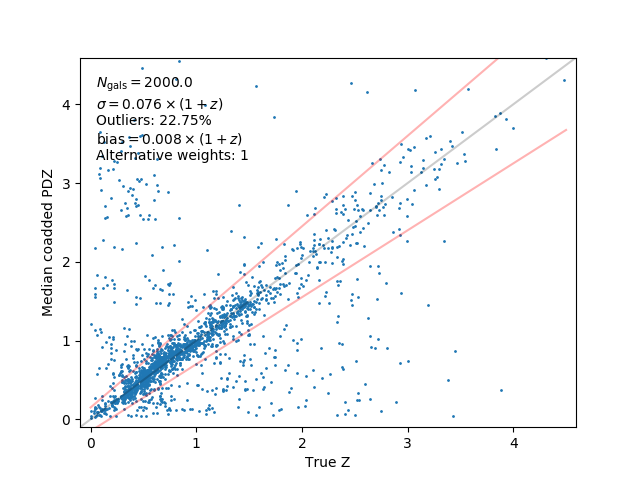

In [6]:
fig = plt.figure()
plot_photoz(fig, t)

In [7]:
def get_neighbors_and_weights(target, reference_catalog):
    types=list(map(lambda d: d[1], reference_catalog.dtype.descr))
    neighbors = Table(None, names=tuple(reference_catalog.colnames), dtype=tuple(types))
    neighbors_w = []
    for n, w in zip(target['NeighborIDs'], target['NeighborWeights']):
        neighbors.add_row(reference_catalog[reference_catalog['ID'] == n][0])
        neighbors_w.append(w)
    return neighbors, neighbors_w

In [9]:
np.abs(t['z_true'] - t['CoaddedPdz_50']).argmin()

343

In [10]:
target_obj = t[343]
target_obj['z_true'] - target_obj['CoaddedPdz_50']

1.0728836e-05

In [11]:
neighbors, neighbors_w = get_neighbors_and_weights(target_obj, ref)

In [12]:
def plot_neighbours_plane(target, neighbors, neighbors_w, x, y, color_map):  
    if type(x) == tuple:
        nx, tx = x
    else:
        nx, tx = x, x
    
    if type(y) == tuple:
        ny, ty = y
    else:
        ny, ty = y, y
    
    scatter = plt.scatter(neighbors[nx], neighbors[ny], c=neighbors_w, cmap=color_map)
    plt.errorbar(
        [target[f'{tx}_obs']], [target[f'{ty}_obs']],
        xerr=[target[f'{tx}_obs_err']],
        yerr=[target[f'{ty}_obs_err']],
        fmt='o', color='r'
    )
    plt.xlabel(x)
    plt.ylabel(y)
    plt.colorbar(scatter)

<IPython.core.display.Javascript object>


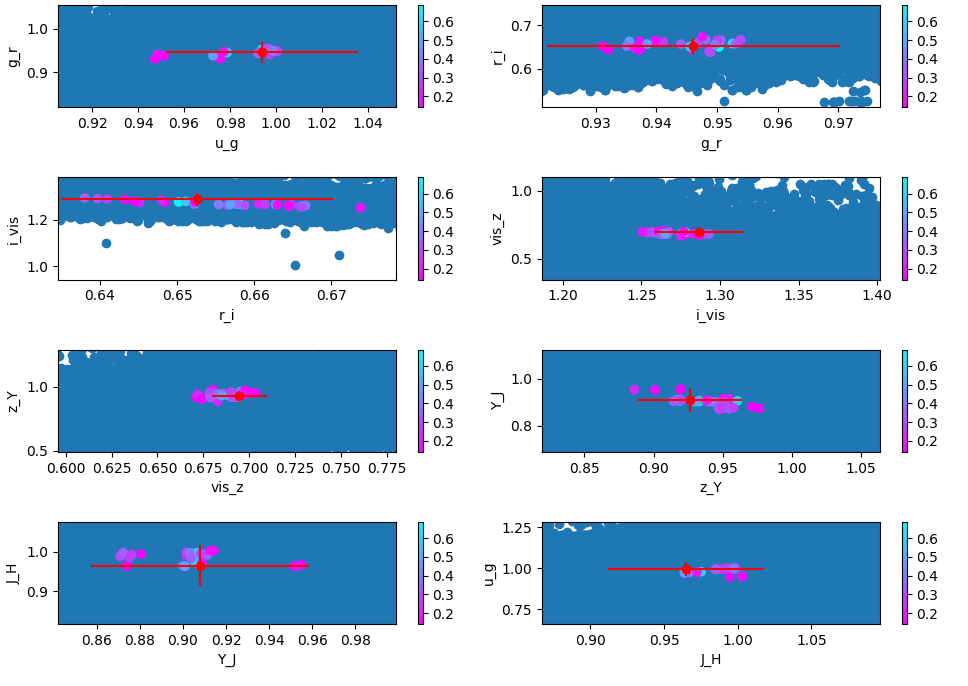

In [13]:
color_map = plt.get_cmap('cool_r')
plt.figure()
plt.subplot(4, 2, 1)
plt.scatter(ref['u_g'], ref['g_r'])
plot_neighbours_plane(target_obj, neighbors, neighbors_w, 'u_g', 'g_r', color_map)
plt.subplot(4, 2, 2)
plt.scatter(ref['g_r'], ref['r_i'])
plot_neighbours_plane(target_obj, neighbors, neighbors_w, 'g_r', 'r_i', color_map)
plt.subplot(4, 2, 3)
plt.scatter(ref['r_i'], ref['i_vis'])
plot_neighbours_plane(target_obj, neighbors, neighbors_w, 'r_i', 'i_vis', color_map)
plt.subplot(4, 2, 4)
plt.scatter(ref['i_vis'], ref['vis_z'])
plot_neighbours_plane(target_obj, neighbors, neighbors_w, 'i_vis', 'vis_z', color_map)
plt.subplot(4, 2, 5)
plt.scatter(ref['vis_z'], ref['z_Y'])
plot_neighbours_plane(target_obj, neighbors, neighbors_w, 'vis_z', 'z_Y', color_map)
plt.subplot(4, 2, 6)
plt.scatter(ref['z_Y'], ref['Y_J'])
plot_neighbours_plane(target_obj, neighbors, neighbors_w, 'z_Y', 'Y_J', color_map)
plt.subplot(4, 2, 7)
plt.scatter(ref['Y_J'], ref['J_H'])
plot_neighbours_plane(target_obj, neighbors, neighbors_w, 'Y_J', 'J_H', color_map)
plt.subplot(4, 2, 8)
plt.scatter(ref['J_H'], ref['u_g'])
plot_neighbours_plane(target_obj, neighbors, neighbors_w, 'J_H', 'u_g', color_map)
plt.tight_layout(pad=0., w_pad=0., h_pad=0.)